<a href="https://colab.research.google.com/github/lizokkolobok/Quads-project/blob/main/Quads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 39.8 MB/s eta 0:00:00


# **Импорты, вводные**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pulp import *

# **Квадраты**

In [3]:
class Rectangle:
  def __init__(self, x0, y0, w, h):
    self.w, self.h = w, h
    self.x0, self.y0 = x0, y0

  def S(self):
    return self.w * self.h

  def draw(self, ax, label=""):
    ax.plot([self.x0, self.x0 + self.w, self.x0 + self.w, self.x0, self.x0],
            [self.y0, self.y0, self.y0 + self.h, self.y0 + self.h, self.y0],
            label=label)

  def get_ratio(self):
    w, h = self.w, self.h
    while True:
      m = int(min(w, h))
      no_delim_found = True
      for d in [2] + list(range(3, m + 1, 2)):
        if w % d == 0 and h % d == 0:
          w /= d
          h /= d
          no_delim_found = False
          break
      if no_delim_found:
          break
    return (int(w), int(h))

class Square(Rectangle):
  def __init__(self, x0, y0, a):
    super().__init__(x0, y0, a, a)
    self.a = self.w

  def split(self, tgt_num):
    if tgt_num == 1:
      return [self] # [Square(self.x0, self.y0, self.a)]
    if tgt_num in [2, 3, 5]:
      raise ValueError("No way!")
    if tgt_num == 4:
      return self._split_in_4()
    elif tgt_num == 6:
      return self._split_in_6()
    elif tgt_num == 8:
      return self._split_in_8()
    else:
      raise ValueError("Too complex tgt_num! Reduce to 4, 6 or 8!")

  def _split_in_4(self):
      return self._split_w_1big(4)

  def _split_w_1big(self, n):
      if n % 2 != 0:
        raise ValueError("n must be even!")
      k = n // 2
      subs = []
      b_x_corner, b_y_corner = np.random.randint(0,2,2)
      subs += [Square(self.x0 + b_x_corner * (self.a / k),
                      self.y0 + b_y_corner * (self.a / k),
                      self.a * (k - 1) / k)]
      subs += [Square(self.x0 + i * (self.a / k),
                      (self.a * (k - 1) / k) * (1 - b_y_corner),
                      self.a / k )
              for i in range(k)]
      subs += [Square((self.a * (k - 1) / k) * (1 - b_x_corner),
                      self.y0 + i * (self.a / k) + b_y_corner * (self.a / k),
                      self.a / k )
              for i in range(k - 1)]
      return subs

  def _split_in_6(self):
      return self._split_w_1big(6)

  def _split_in_8(self):
      return self._split_w_1big(8)

# **Проверка кода разделения квадрата на квадраты**

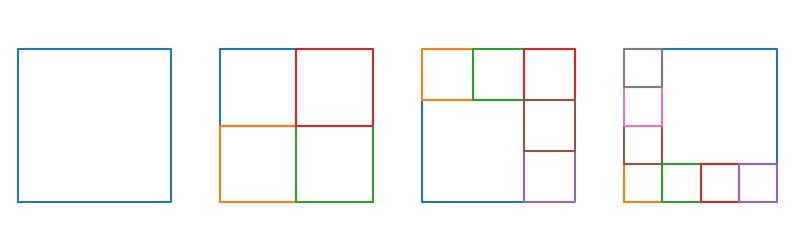

In [4]:
_, axs = plt.subplots(1, 4, figsize=(10, 3))

qq = Square(0,0, 10)

qq.draw(axs[0])
axs[0].axis("equal")
axs[0].axis("off")

for i, n in enumerate([4,6,8]):
  for j, sub in enumerate(qq.split(n)):
        sub.draw(axs[1 + i])
        axs[1 + i].set_xlim(0,10)
        axs[1 + i].set_ylim(0,10)
        axs[1 + i].axis("equal")
        axs[1 + i].axis("off")
plt.show()

# **Жадный алгоритм для заполнения прямоугольного поля квадратами**

In [5]:
def fill_field_with_squares(W, H, verbose=False):
    ratio = Rectangle(0,0,W,H).get_ratio()
    rect = Rectangle(0,0,*ratio)

    w, h = rect.w, rect.h
    x0, y0 = rect.x0, rect.y0
    rects = []
    while w != h:
        a = min(w, h)
        rects += [Square(x0, y0, a)]
        if verbose:
            print(f"added rect ({x0},{y0}) {a}x{a}")

        x0, y0 = x0 + (a == h) * a, y0 + (a == w) * a
        w, h = w - (a == h) * a, h - (a == w) * a
        # h -= (a == w) * a
        if verbose:
            print(f"\tnew vals: x0 = {x0}, y0 = {y0}, w = {w}, h = {h}")

    rects += [Square(x0, y0, w)]

    out = {"field": {"w": W, "H": H},
           "ratio": ratio,
           "rects": rects}

    return out

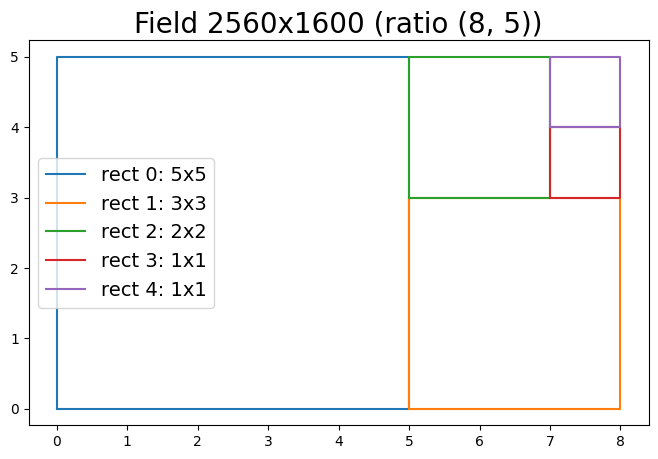

In [6]:
filling = fill_field_with_squares(2560, 1600)

fig, ax = plt.subplots(1,1,figsize=filling["ratio"])
plt.axis("equal")

for i, rect in enumerate(filling["rects"]):
  rect.draw(ax, label=f"rect {i}: {rect.w}x{rect.h}")

plt.title(f"Field {filling['field']['w']}x{filling['field']['H']} (ratio {filling['ratio']})", fontsize=20)
plt.xticks(np.arange(0, filling["ratio"][0] + 1))
plt.yticks(np.arange(0, filling["ratio"][1] + 1))
plt.legend(prop={"size":14})
plt.show()

# **Размещение фото в квадратах**

# **Постановка задачи**

In [7]:
def make_problem(n_likes, sq_squares):
    problem = LpProblem("collage", LpMinimize)
    M = 1e5

    # Нормируем число лайков на фото
    n_likes = np.array(n_likes) / sum(n_likes)
    # Нормируем размеры квадратов
    sq_squares = np.array(sq_squares) / sum(sq_squares)

    # x_ij = {1, фото i лежит в квадрате j; 0, иначе}
    xs = LpVariable.dicts("x",
                          ((i, j) for i in range(len(n_likes)) for j in range(len(sq_squares))),
                          cat="Binary")
    d1 = LpVariable.dicts("d1",
                          (j for j in range(len(sq_squares))),
                          cat="Continuous")
    d2 = LpVariable.dicts("d2",
                          (j for j in range(len(sq_squares))),
                          cat="Continuous")
    d = LpVariable.dicts("d",
                         (j for j in range(len(sq_squares))),
                         cat="Continuous")
    # s_j - Суммарное число "лайков" в квадрате j
    s = LpVariable.dicts("s",
                         (j for j in range(len(sq_squares))),
                         lowBound=0,
                         cat="Continuous")
    q = LpVariable.dicts("q",
                         ((j, k) for j in range(len(sq_squares)) for k in range(2)),
                         cat="Binary")

    # Каждое фото должно быть размещено ровно в одном квадрате
    for i in range(len(n_likes)):
        problem += lpSum([xs[(i,j)] for j in range(len(sq_squares))]) == 1

    for j in range(len(sq_squares)):
        # s_j = \sum_i{x_{i,j} \cdot likes[i]}
        problem += lpSum([xs[(i,j)] * n_likes[i] for i in range(len(n_likes))]) == s[j]

        # В каждом квадрате должно быть по крайней мере одно фото
        problem += lpSum([xs[(i,j)] for i in range(len(n_likes))]) >= 1

        # Ограничения для числа фото в квадрате (см. объяснение выше)
        problem += q[(j, 1)] <= q[(j, 0)]
        problem += lpSum([xs[(i,j)] for i in range(len(n_likes))]) >= 1 + 3 * q[(j, 0)] + 2 * q[(j, 1)]
        problem += lpSum([xs[(i,j)] for i in range(len(n_likes))]) <= 1 + 3 * q[(j, 0)] + 2 * q[(j, 1)] + M * q[(j, 1)]

        # Для целевой функции (см. объяснение выше)
        problem += sq_squares[j] - s[j] == d1[j]
        problem += s[j] - sq_squares[j] == d2[j]
        problem += d[j] >= d1[j]
        problem += d[j] >= d2[j]

    problem += lpSum([d[j] for j in range(len(sq_squares))])

    return problem

In [14]:
# Зададим случайное число лайков на фото
ph_likes = np.random.randint(1, 100, 20)
# Будем использовать квадраты из сгенерированного выше заполнения поля
squares = [rect.S() for rect in filling["rects"]]

In [15]:
prob = make_problem(ph_likes, squares)

In [16]:
prob.solve()

1

In [17]:
LpStatus[prob.status]

'Optimal'

In [18]:
print("Значение целевой функции:", prob.objective.value())

Значение целевой функции: 0.00866728801


In [19]:
deploy = np.array([[prob.variablesDict()[f"x_({i},_{j})"].value()
                  for j in range(len(squares))]
                  for i in range(len(ph_likes))]).astype(int)

In [20]:
print("Число фото в квадратах:", *deploy.sum(axis=0))

Число фото в квадратах: 9 5 2 3 1


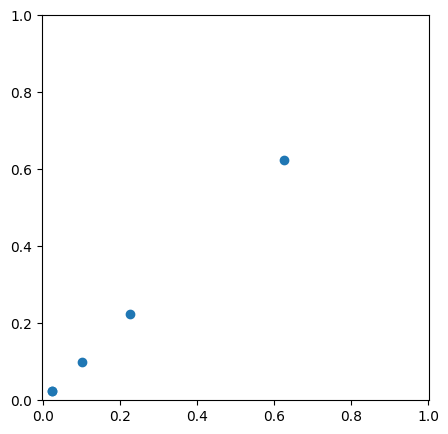

In [21]:
_, ax = plt.subplots(1,1,figsize=(5,5))

mod_ph_likes = ph_likes / sum(ph_likes)
plt_xs = [deploy[:,j] @ mod_ph_likes for j in range(len(squares))]

plt_ys = np.array(squares) / sum(squares)

ax.scatter(plt_xs, plt_ys)
ax.plot([0,0],[1,1])

plt.axis("equal")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

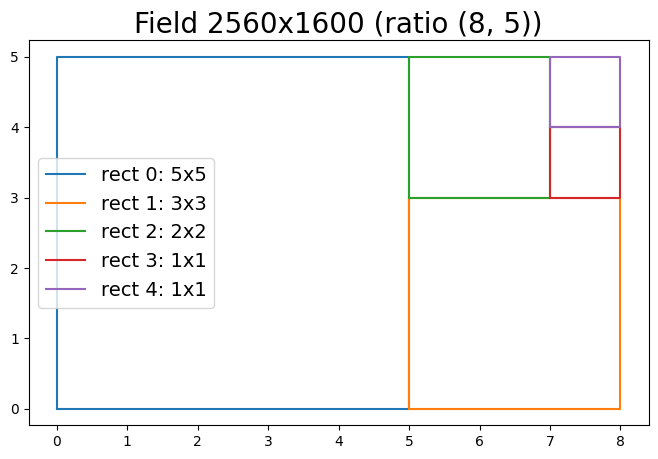

In [16]:
filling = fill_field_with_squares(2560, 1600)

fig, ax = plt.subplots(1, 1, figsize=filling["ratio"])
plt.axis("equal")
for i, rect in enumerate(filling["rects"]):
    rect.draw(ax, label=f"rect {i}: {rect.w}x{rect.h}")

plt.title(f"Field {filling['field']['w']}x{filling['field']['H']} (ratio {filling['ratio']})", fontsize=20)
plt.xticks(np.arange(0, filling["ratio"][0] + 1))
plt.yticks(np.arange(0, filling["ratio"][1] + 1))
plt.legend(prop={"size": 14})
plt.show()

In [17]:
def pulp_to_deploy(var_dict, n_photos, n_squares):
    deploy = np.array([[prob.variablesDict()[f"x_({i},{j})"].value
                       for j in range(n_squares)]
                       for i in range(n_photos)]).astype(int)
    return deploy

In [18]:
# Зададим случайное число лайков на фото
ph_likes = np.random.randint(1, 100, 25)
# Будем использовать квадраты из сгенерированного выше заполнения поля
quads = filling["rects"]
quad_squares = [rect.S() for rect in quads]

In [19]:
#prob = make_problem(ph_likes, quad_squares)
#prob.solve()
#init_deploy = pulp_to_deploy(prob.variablesDict(), len(ph_likes), len(quads))

#q_ph_inds = [np.where(init_deploy[:, i] == 1)[0] for i in range(len(quads))]

KeyError: 'x_(0,0)'

In [7]:
import random
import numpy as np
from pulp import *
import matplotlib.pyplot as plt

In [8]:
def split_options(n):
    if n == 1:
        return [{1: 1}]
    if n < 0 or n in [2, 3, 5]:
        return []
    if n == 4: return [{1/2: 4}]
    if n == 6: return [{2/3: 1, 1/3: 5}]
    if n == 8: return [{3/4: 1, 1/4: 7}]

    out_opts = []
    for k in (3, 5, 7):
        for opt in split_options(n - k):
            for quad_type in opt:
                new_opt = dict(opt)
                if opt[quad_type] == 1:
                    del new_opt[quad_type]
                else:
                    new_opt[quad_type] -= 1
                if k == 3:
                    new_opt[quad_type / 2] = new_opt.get(quad_type / 2, 0) + 4
                elif k == 5:
                    new_opt[quad_type * 2/3] = new_opt.get(quad_type * 2/3, 0) + 1
                    new_opt[quad_type * 1/3] = new_opt.get(quad_type * 1/3, 0) + 5
                else:
                    new_opt[quad_type * 3/4] = new_opt.get(quad_type * 3/4, 0) + 1
                    new_opt[quad_type * 1/4] = new_opt.get(quad_type * 1/4, 0) + 7

                out_opts.append(new_opt)
                print(f"Generated option for k={k}, n={n}: {new_opt}")
    return out_opts

def main():
    n = 10
    ways = split_options(n)
    print(f"All ways to divide a square into {n} smaller squares:")
    for way in ways:
        print(way)

if __name__ == "__main__":
    main()

Generated option for k=3, n=7: {0.5: 3, 0.25: 4}
Generated option for k=3, n=10: {0.5: 2, 0.25: 8}
Generated option for k=3, n=10: {0.5: 3, 0.25: 3, 0.125: 4}
All ways to divide a square into 10 smaller squares:
{0.5: 2, 0.25: 8}
{0.5: 3, 0.25: 3, 0.125: 4}


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus

In [10]:
class Square:
    def __init__(self, x0, y0, a):
        self.x0 = x0
        self.y0 = y0
        self.a = a

    def split(self, tgt_num):
        if tgt_num == 1:
            return [self]
        if tgt_num == 4:
            return self._split_in_4()
        elif tgt_num == 6:
            return self._split_in_6()
        elif tgt_num == 8:
            return self._split_in_8()
        else:
            raise ValueError("Too complex tgt_num! Reduce to 4, 6, or 8!")

    def _split_w_1big(self, n):
        if n % 2 != 0:
            raise ValueError("n must be even!")
        k = n // 2
        subs = []
        b_x_corner, b_y_corner = np.random.randint(0, 2, 2)
        subs.append(Square(self.x0 + b_x_corner * (self.a / k),
                           self.y0 + b_y_corner * (self.a / k),
                           self.a * (k - 1) / k))
        subs.extend([Square(self.x0 + i * (self.a / k),
                            self.y0 + (self.a * (k - 1) / k) * (1 - b_y_corner),
                            self.a / k) for i in range(k)])
        subs.extend([Square(self.x0 + (self.a * (k - 1) / k) * (1 - b_x_corner),
                            self.y0 + i * (self.a / k) + b_y_corner * (self.a / k),
                            self.a / k) for i in range(k - 1)])

        return subs

    def _split_in_4(self):
        return self._split_w_1big(4)

    def _split_in_6(self):
        return self._split_w_1big(6)

    def _split_in_8(self):
        return self._split_w_1big(8)

In [11]:
def split_options(n):
    if n == 1:
        return [{1: 1}]
    if n < 0 or n in [2, 3, 5]:
        return []
    if n == 4:
        return [{1/2: 4}]
    if n == 6:
        return [{2/3: 1, 1/3: 5}]
    if n == 8:
        return [{3/4: 1, 1/4: 7}]

    out_opts = []
    for k in (3, 5, 7):
        for opt in split_options(n - k):
            for quad_type in list(opt.keys()):
                new_opt = dict(opt)
                if new_opt[quad_type] == 1:
                    del new_opt[quad_type]
                else:
                    new_opt[quad_type] -= 1
                if k == 3:
                    new_opt[quad_type / 2] = new_opt.get(quad_type / 2, 0) + 4
                elif k == 5:
                    new_opt[quad_type * 2/3] = new_opt.get(quad_type * 2/3, 0) + 1
                    new_opt[quad_type * 1/3] = new_opt.get(quad_type * 1/3, 0) + 5
                else:
                    new_opt[quad_type * 3/4] = new_opt.get(quad_type * 3/4, 0) + 1
                    new_opt[quad_type * 1/4] = new_opt.get(quad_type * 1/4, 0) + 7

                out_opts.append(new_opt)
    return out_opts


In [12]:
def make_problem(n_likes, sq_squares):
    problem = LpProblem("collage", LpMinimize)
    M = 1e5

    n_likes = np.array(n_likes) / sum(n_likes)
    sq_squares = np.array(sq_squares) / sum(sq_squares)

    xs = LpVariable.dicts("x",
                          ((i, j) for i in range(len(n_likes)) for j in range(len(sq_squares))),
                          cat="Binary")
    d1 = LpVariable.dicts("d1",
                          (j for j in range(len(sq_squares))),
                          cat="Continuous")
    d2 = LpVariable.dicts("d2",
                          (j for j in range(len(sq_squares))),
                          cat="Continuous")
    d = LpVariable.dicts("d",
                          (j for j in range(len(sq_squares))),
                          cat="Continuous")
    s = LpVariable.dicts("s",
                          (j for j in range(len(sq_squares))),
                         lowBound=0,
                          cat="Continuous")

    for i in range(len(n_likes)):
        problem += lpSum([xs[(i,j)] for j in range(len(sq_squares))]) == 1

    for j in range(len(sq_squares)):
        problem += lpSum([xs[(i,j)] * n_likes[i] for i in range(len(n_likes))]) == s[j]
        problem += lpSum([xs[(i,j)] for i in range(len(n_likes))]) >= 1
        problem += sq_squares[j] - s[j] == d1[j]
        problem += s[j] - sq_squares[j] == d2[j]
        problem += d[j] >= d1[j]
        problem += d[j] >= d2[j]

    problem += lpSum([d[j] for j in range(len(sq_squares))])

    return problem

In [22]:
def recursive_refinement(ph_likes, initial_quads, max_iterations=10):
    quads = initial_quads
    q_ph_inds = [np.where(deploy[:, i] == 1)[0] for i in range(len(quads))]

    iteration = 0
    while iteration < max_iterations:
        split_q_ind = 0
        while split_q_ind < len(quads) and len(q_ph_inds[split_q_ind]) == 1:
            split_q_ind += 1
        if split_q_ind == len(quads):
            break

        app_quads = quads[split_q_ind].split([6, 4, 8][len(q_ph_inds[split_q_ind]) % 3])
        app_q_squares = [rect.S() for rect in app_quads]

        prob = make_problem(ph_likes[q_ph_inds[split_q_ind]], app_q_squares)
        if prob.solve() == 1:
            deploy = pulp_to_deploy(prob.variablesDict(), len(q_ph_inds[split_q_ind]), len(app_quads))
            app_q_ph_inds = [np.where(deploy[:, i] == 1)[0] for i in range(len(app_quads))]
            app_q_ph_inds = [np.array([q_ph_inds[split_q_ind][loc_ind] for loc_ind in a]) for a in app_q_ph_inds]
            quads = quads[:split_q_ind] + quads[split_q_ind + 1:] + app_quads
            q_ph_inds = q_ph_inds[:split_q_ind] + q_ph_inds[split_q_ind + 1:] + app_q_ph_inds
        else:
            raise Exception("Optimization failed during recursive refinement")

        iteration += 1

    return quads, q_ph_inds

# Apply recursive refinement to the initial field
refined_quads, refined_q_ph_inds = recursive_refinement(ph_likes, initial_field["rects"])

NameError: name 'initial_field' is not defined

In [23]:
def evaluate_collage(n_likes, square):
    split_opts = split_options(square)
    best_score = float('inf')
    best_layout = None

    for opt in split_opts:
        sq_squares = list(opt.keys())
        prob = make_problem(n_likes, sq_squares)
        prob.solve()

        if LpStatus[prob.status] == 'Optimal':
            score = prob.objective.value()
            if score < best_score:
                best_score = score
                best_layout = prob

    if best_layout is None:
        print("No optimal solution found.")
    else:
        print("Optimal solution found.")

    return best_score, best_layout

In [24]:
def visualize_collage(n_likes, best_layout, k, best_score):
    split_opts = split_options(k)
    if not split_opts:
        print(f"No valid split options for k={k}")
        return

    squares = split_opts[0]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    remaining_space = [(0, 0, 1, 1)]
    photo_positions = {}

    color_map = plt.get_cmap('tab20')

    for var in best_layout.variables():
        if var.name.startswith('x_') and var.varValue == 1:
            name_parts = var.name.replace('x_(', '').replace(')', '').split(',_')
            i = int(name_parts[0])
            j = int(name_parts[1])

            try:
                size = list(squares.keys())[j]
            except IndexError:
                print(f"IndexError: j={j}, squares={list(squares.keys())}")
                continue

            for index, (x, y, w, h) in enumerate(remaining_space):
                if w >= size and h >= size:
                    photo_positions[i] = (x, y, size)
                    remaining_space.pop(index)
                    new_spaces = [
                        (x + size, y, w - size, h),
                        (x, y + size, w, h - size),
                        (x + size, y + size, w - size, h - size)
                    ]
                    for space in new_spaces:
                        if space[2] > 0 and space[3] > 0:
                            remaining_space.append(space)
                    remaining_space = sorted(remaining_space, key=lambda sp: (sp[1], sp[0]))  # Prioritize top-left spaces
                    break

    print("Photo positions:", photo_positions)

    for i, (x, y, size) in photo_positions.items():
        rect = plt.Rectangle((x, y), size, size, facecolor=color_map(i / len(n_likes)), edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        ax.text(x + size / 2, y + size / 2, f"Photo {i}\nLikes: {n_likes[i]}", ha='center', va='center', fontsize=8, color='black')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.grid(True)
    plt.gca().invert_yaxis()
    plt.title(f"Best Score: {best_score}")
    plt.show()

Optimal solution found.
Photo positions: {0: (0, 0, 0.5), 1: (0.5, 0, 0.25), 2: (0.5, 0.25, 0.5), 3: (0.75, 0, 0.25), 4: (0.75, 0.25, 0.25), 5: (0, 0.5, 0.5), 6: (0.5, 0.5, 0.5)}


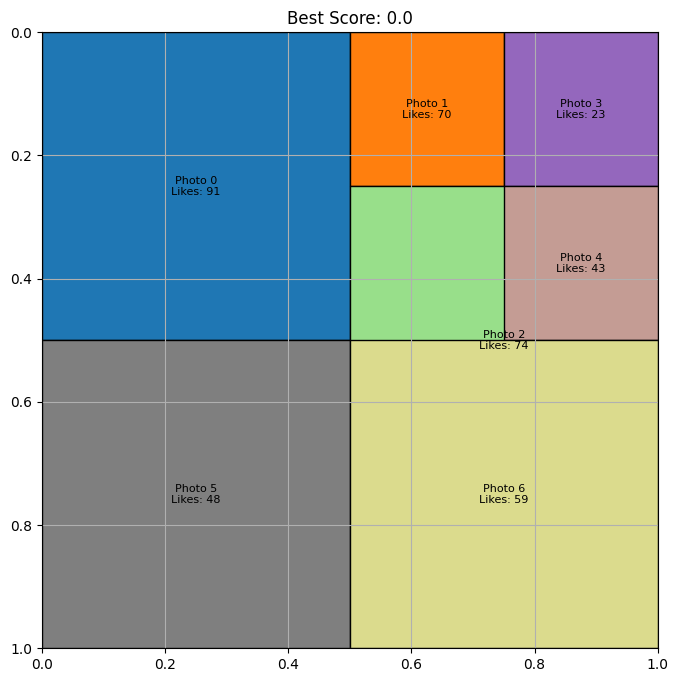

Best Score: 0.0


In [40]:
ph_likes = np.random.randint(1, 100, 7)
number_of_photos = 7

best_score, best_layout = evaluate_collage(ph_likes, number_of_photos)
visualize_collage(ph_likes, best_layout, number_of_photos, best_score)
print(f"Best Score: {best_score}")